In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

#set backend to cpu
bm.set_platform('cpu') 

/Users/chutianhao/opt/anaconda3/envs/bp311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### define a function to get step size, averaged firing rate and bump_center

In [2]:
replay_dur = 10000      #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

def get_results(mbar, sigma_m=0.1, sigma_u=0.02, oscillation_strength=0.5, oscilation_period=400):
    #initialize the network
    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=sigma_m, sigma_u=sigma_u)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    x_time, x_dim = Iext.shape
    x = np.arange(x_time)
    
    #geterante the oscillatory input, the period is oscilation_period ms, the strength is oscilaltion_strength
    #the shape is the same as Iext, using sin function
    oscillatory_input = oscillation_strength * np.sin(2*np.pi*x/oscilation_period)
    #subtratc the minimum value to make sure the oscillatory_input is always positive
    #oscillatory_input = oscillatory_input - np.min(oscillatory_input)
    #copy each value in oscillatory_input into dimension x_dim, make oscillatory_input the same shape as Iext
    oscillatory_input = np.tile(oscillatory_input, (x_dim, 1)).T
    
    
    Iext = Iext + oscillatory_input
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center', 'r'],
                        progress_bar=False)

    replay_runner_1.run(length)

    replay_start = int(init_dur/replay_runner_1.dt)

    bump_center = replay_runner_1.mon.center
    #squeeze the array
    bump_center = np.squeeze(bump_center)[replay_start:]

    fr = bm.as_numpy(replay_runner_1.mon.r)
    fr = fr[replay_start:, :]

    #get the mean fr for each time step]
    fr_thres = np.max(fr)
    fr = np.where(fr<fr_thres/5, 0, fr)
    ave_fr = np.max(fr, axis=1)
    # ave_fr = np.mean(fr, axis=1)

    #caulcte the stepsize of the bump_center
    
    stepsize = np.diff(bump_center)
    #remove the effect of periodic boundary, if the stepsize is larger than pi, then minus 2pi, if the stepsize is smaller than -pi, then add 2pi
    stepsize = np.where(stepsize>np.pi, stepsize-2*np.pi, stepsize)
    stepsize = np.where(stepsize<-np.pi, stepsize+2*np.pi, stepsize)
    
    stepsize = np.abs(stepsize)
    #add 0 at the beginning of the array
    stepsize = np.insert(stepsize, 0, 0, axis=0)
    
    return stepsize, ave_fr, bump_center, oscillatory_input



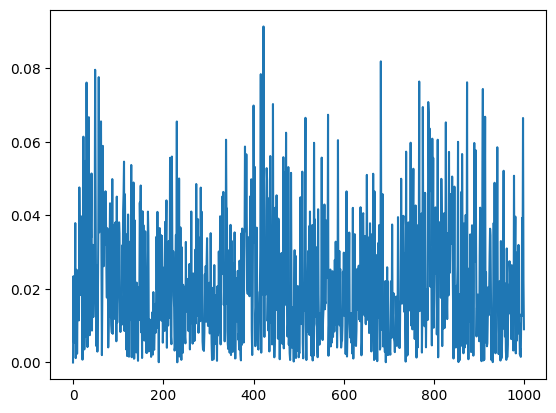

In [9]:

#!!! @Tianhao: change the mbar value to add adaptation to the network 

stepsize, mean_fr, bump_center, oscillatory_input = get_results(mbar=0.99, sigma_m=0.001, sigma_u=0.0005,  oscillation_strength=0.015, oscilation_period=400)


#change stepsize from m to cm
stepsize = stepsize * 100
#time all_fr_list by 1000 to get Hz 
mean_fr = mean_fr * 1000
# plt.plot(mean_fr[:1000])
plt.plot(stepsize[:1000])

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_48630/1233270950.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "#009FB9" (-> color=(0.0, 0.6235294117647059, 0.7254901960784313, 1.0)). The keyword argument will take precedence.
  ax1.plot(mean_fr_probe, linecolor, color='grey')


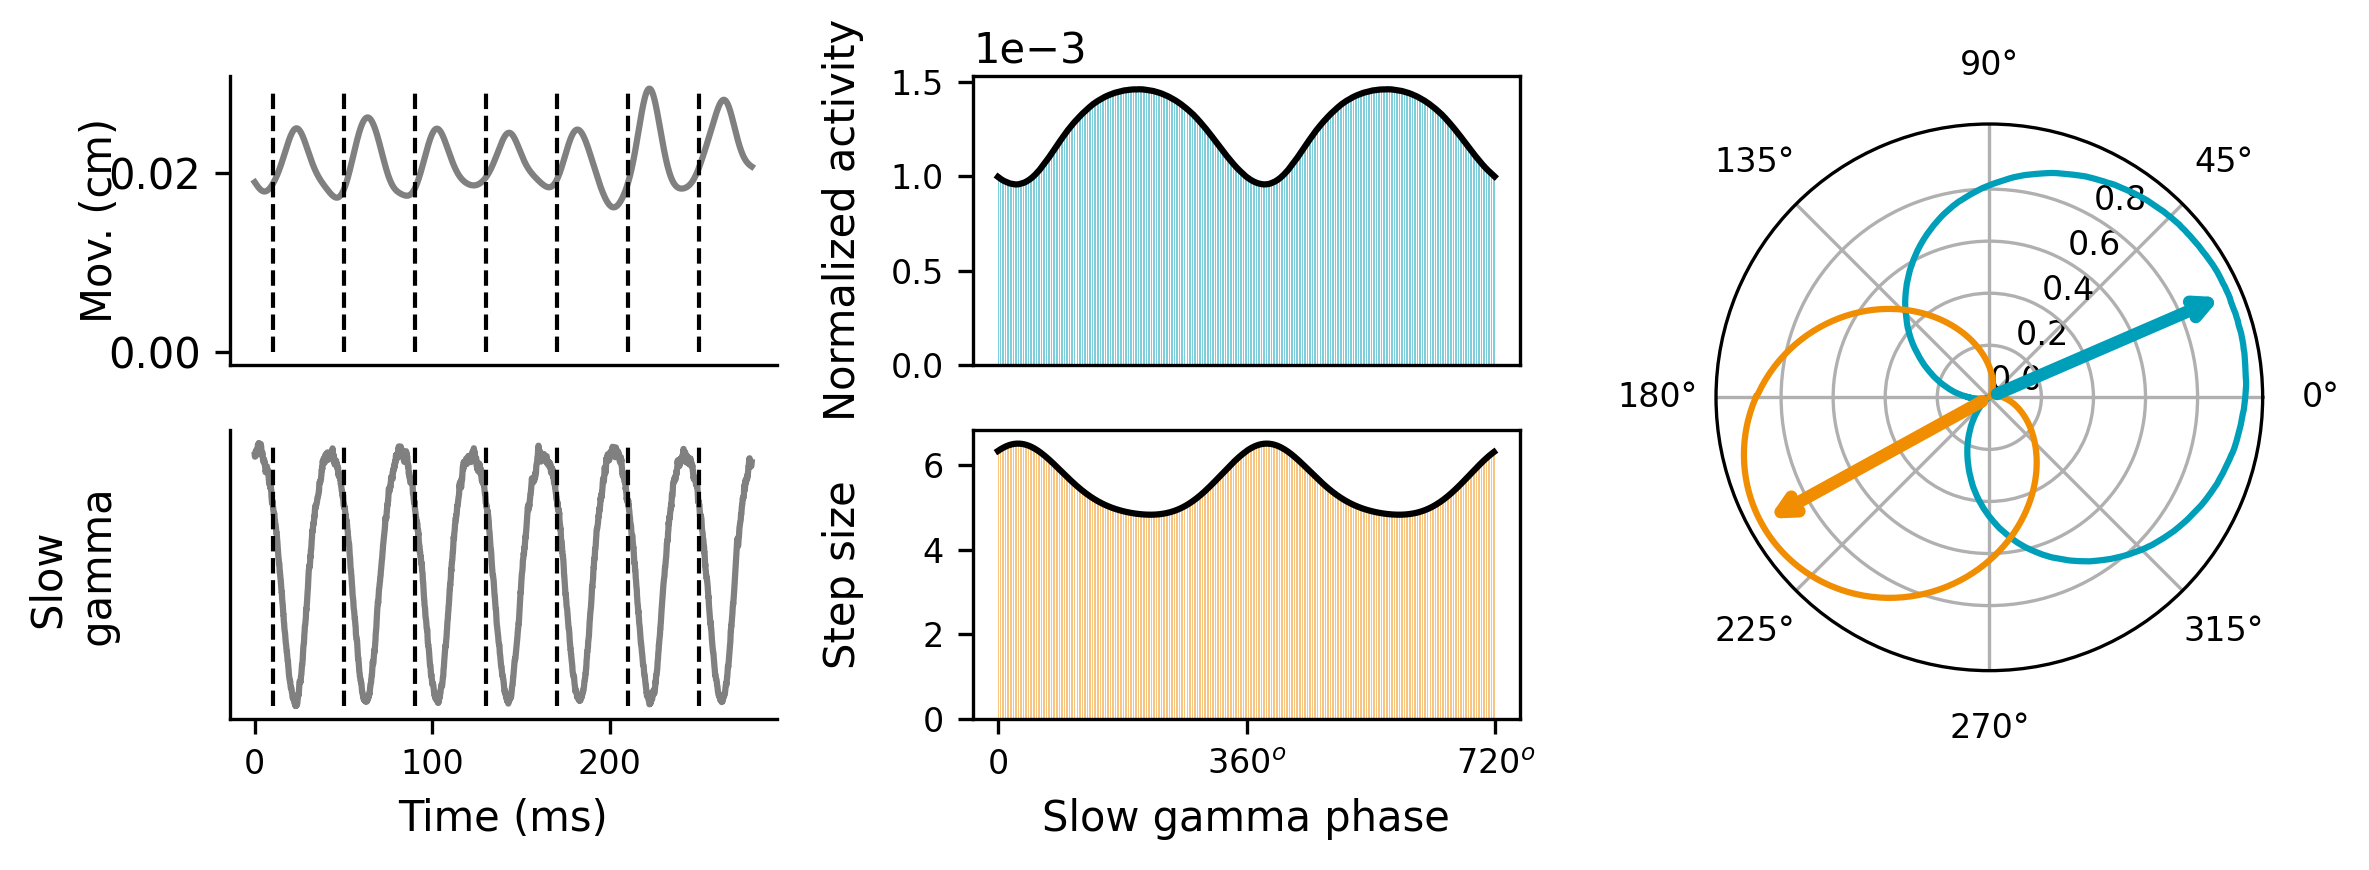

In [10]:
    
init = 5000
stepsize = scipy.ndimage.gaussian_filter1d(stepsize, sigma=50)
st = stepsize[init:init+2800]
mr = oscillatory_input[init:init+2800,0]
mean_fr_probe = mean_fr[init:init+2800]
Peaks,_ = scipy.signal.find_peaks(-mr)


fig = plt.figure(figsize=(8, 3), dpi=300)
labelsize = 10
ticksize = 8
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1])

linecolor = '#009FB9'

###########
#subplot 0#
###########

ax0 = plt.subplot(gs[0,0])

# 在第一个子图中绘制折线图
ax0.plot(st, color='grey')
# ax0.plot(st, color='#F18D00', marker='o', linestyle='None', markersize=1)

#add vertical lines
for peaks in Peaks:
    ax0.plot([peaks, peaks],[0,np.max(st)],'k--', linewidth=1)

#set right and top spines invisible
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)    
    
#add ylabel
ax0.set_ylabel('Mov. (cm)', fontsize=labelsize)
    
# #add y ticks
# ax0.set_yticks([0, 10, 20])
# #add y tick labels
# ax0.set_yticklabels([0, 10, 20], fontsize=ticksize)
#set xticks off
ax0.set_xticks([])

###########
#subplot 1#
###########

ax1 = plt.subplot(gs[1,0])

ax1.plot(mean_fr_probe, linecolor, color='grey')
for peaks in Peaks:
    ax1.plot([peaks, peaks],[np.min(mean_fr_probe),np.max(mean_fr_probe)],'k--', linewidth=1)

#set top and right spines invisible
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#add xlabel and ylabel and chang label to two lines
ax1.set_xlabel('Time (ms)', fontsize=labelsize)
ax1.set_ylabel('Slow \n gamma', fontsize=labelsize)

#set y ticks off for the second subplot
ax1.set_yticks([])
#set x ticks
ax1.set_xticks([0, 1000, 2000])
#set x tick labels
ax1.set_xticklabels([0, 100, 200], fontsize=ticksize)

#align the ylabels of ax0 and ax1
ax0.yaxis.set_label_coords(-0.2, 0.5)
ax1.yaxis.set_label_coords(-0.2, 0.5)

###########
#subplot 2#
###########

period = 400
phase_step = np.zeros(period)
phase_r = np.zeros(period)
phase = np.linspace(-np.pi, np.pi, period+1)[:-1]
for i in range(int(len(mean_fr) / period)):
    for j in range(period):
        phase_step[j] = phase_step[j] + stepsize[i * period + j]
        phase_r[j] = phase_r[j] + mean_fr[i * period + j]

#add another cycle to the end of the trace
phase1 = phase + np.pi
phase2 = phase+3*np.pi
phase_r1 = phase_r
phase_r2 = phase_r
phase_step1 = phase_step
phase_step2 = phase_step

#concate the two cycles
phase12 = np.append(phase1, phase2)
phase_r12 = np.append(phase_r2, phase_r2)
#normalize phase_r12 to a probability distribution
phase_r12 = phase_r12/np.sum(phase_r12)

phase_step12 = np.append(phase_step1, phase_step2)

ax2 = plt.subplot(gs[0,1])

ax2.plot(phase12, phase_r12, color='k')
ax2.bar(phase12, phase_r12, width=1.2*np.pi/period, color='#009FB9', alpha=0.5)  
#add y label
ax2.set_ylabel('Normalized activity', fontsize=labelsize)
#ylabel in scientific notation
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#set x ticks off
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', labelsize=ticksize)

###########
#subplot 3#
###########

ax3 = plt.subplot(gs[1,1])

ax3.plot(phase12[0:-1], phase_step12[0:-1], color='k')
ax3.bar(phase12, phase_step12, width=1.2*np.pi/period, color='#F18D00', alpha=0.5)
#add y label
ax3.set_ylabel('Step size', fontsize=labelsize)
#ylabel in scientific notation
    

#add x label
ax3.set_xlabel('Slow gamma phase', fontsize=labelsize)

#add xticks
ax3.set_xticks([0, 2*np.pi, 4*np.pi])
#add xticklabels and yticklabels
ax3.set_xticklabels(['0', '$360^o$', '$720^o$'])
#set x and y tick font size
ax3.tick_params(axis='both', which='major', labelsize=ticksize)



#set y tick and fontszie
# ax3.set_yticks([0, 5, 10])
# ax3.set_yticklabels(['0', '5', '10'], fontsize=ticksize)
#align y labels
ax2.yaxis.set_label_coords(-0.2, 0.5)
ax3.yaxis.set_label_coords(-0.2, 0.5)

###########
#subplot 3#
###########

ax3 = plt.subplot(gs[:,2], projection='polar')

period = 400
phase_step = np.zeros(period)
phase_r = np.zeros(period)
phase = np.linspace(-np.pi, np.pi, period+1)[:-1]
for i in range(int(len(mean_fr) / period)):
    for j in range(period):
        phase_step[j] = phase_step[j] + stepsize[i * period + j]
        phase_r[j] = phase_r[j] + mean_fr[i * period + j]
phase_r = (phase_r-np.min(phase_r))/(np.max(phase_r)-np.min(phase_r))
phase_step = (phase_step-np.min(phase_step))/(np.max(phase_step)-np.min(phase_step))

phase = np.append(phase, phase[0])
phase_r = np.append(phase_r, phase_r[0])
phase_step = np.append(phase_step, phase_step[0])

#%%
ax3.plot(phase, phase_r, color='#009FB9')
ax3.plot(phase, phase_step, color='#F18D00')

#calculate peak phase_r and phase_step
peak_phase_r = phase[np.argmax(phase_r)]
peak_phase_step = phase[np.argmax(phase_step)]

#add arrows representing the peak phase_r and phase_step
#pointing from the center to the peak, make the arrow thicker with a arrow style ->
#using annotate function
ax3.annotate("", xy=(peak_phase_r, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='#009FB9', linewidth=3))
ax3.annotate("", xy=(peak_phase_step, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='#F18D00', linewidth=3))
#add grid
ax3.grid(True)

#set tick size
ax3.tick_params(labelsize=ticksize)
ax3.set_rticks([0, 0.2, 0.4, 0.6, 0.8])
#reduce rticks size
for label in ax3.get_yticklabels():
    label.set_fontsize(ticksize)
ax3.set_rlabel_position(60)

plt.tight_layout()

#save
plt.savefig('./Fig5_anti_phase_locking_2.pdf', bbox_inches='tight')

In [ ]:
len(mean_fr)